In [114]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import pytesseract

In [115]:
path = 'All_Data/'
files = sorted(os.listdir(path))

In [116]:
def img_show(img, code=cv2.COLOR_BGR2RGB):
    cv_rgb = cv2.cvtColor(img, code)
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.imshow(cv_rgb)
    fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


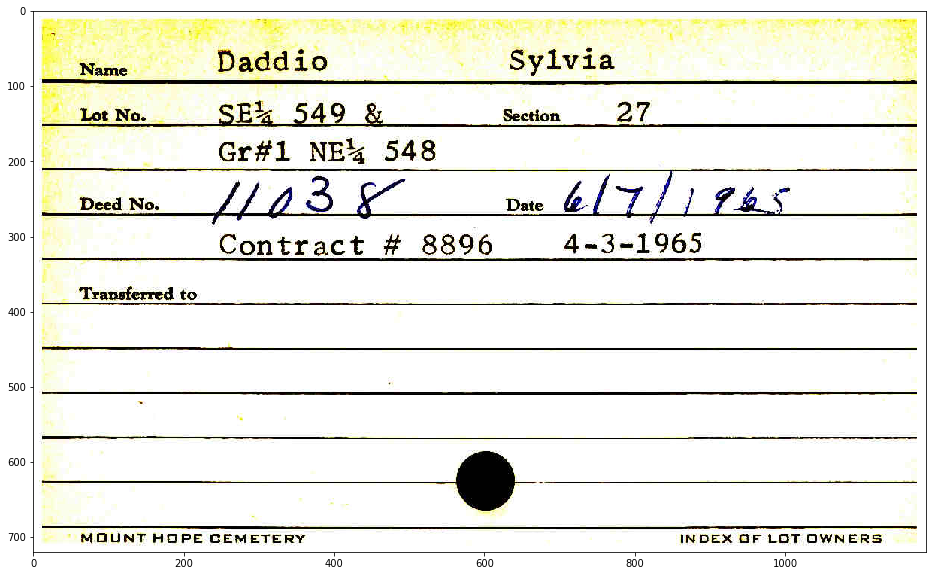

In [117]:
# index of image
i = 1
im = cv2.imread(path+files[i], 1)
# original image
img_show(im)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


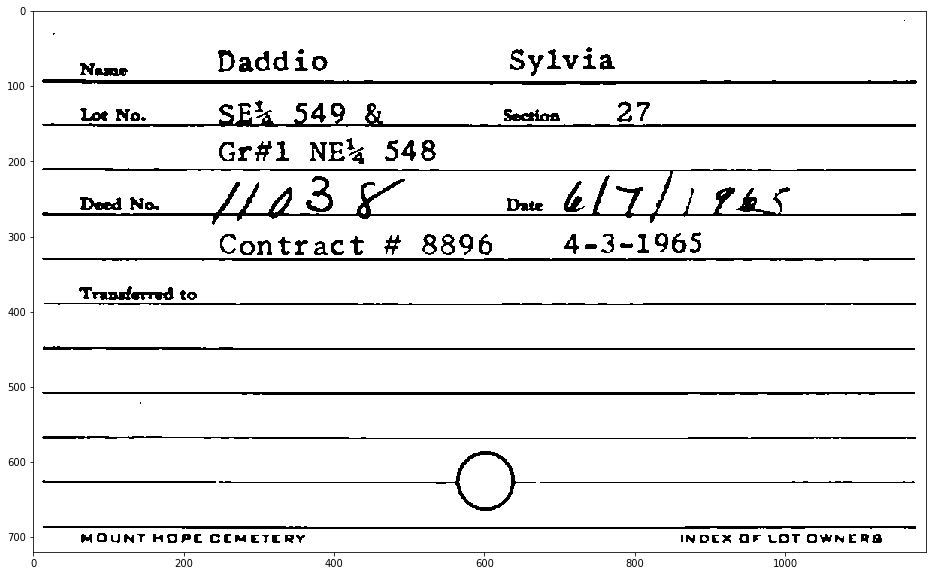

In [131]:
# preprocess:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, th1 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
th3 = cv2.adaptiveThreshold(th1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                cv2.THRESH_BINARY, 11, 2)
blur = cv2.medianBlur(th3, 3)  # ksize: 3*3
blur = cv2.medianBlur(blur, 3)

img_show(blur)

In [132]:
# obtain first line
h, w = gray.shape
# horizontal line
horizontal_lines = []
for i in range(h - 1):
    # find the split line
    if abs(np.mean(blur[i, :]) - np.mean(blur[i + 1, :])) > 100:
        # plot the line
        horizontal_lines.append([0, i, w, i])
if horizontal_lines and horizontal_lines[0][1] < 150:
    first_line = horizontal_lines[0]
else:
    first_line = [0, 104, w, 104]
    
print(first_line)

[0, 93, 1188, 93]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


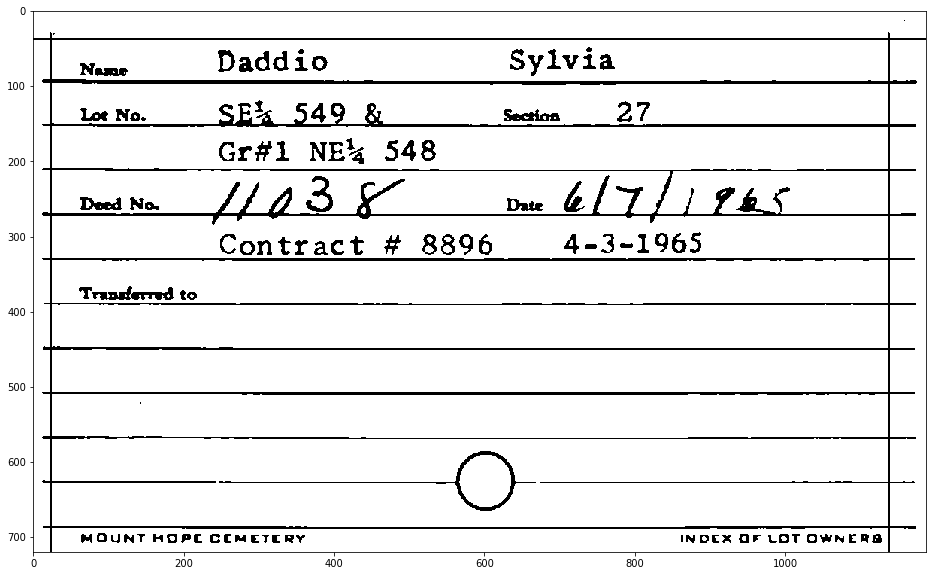

In [133]:
# draw auxiliary lines:
lines = [[23, 30, 23, h], [w-50, 30, w-50, h]]
first_line[1] -= 55
first_line[3] -= 55
lines.append(first_line)
for l in lines:
    ready_image = cv2.line(blur, (l[0], l[1]), (l[2], l[3]), (0, 0, 0), 2)
img_show(ready_image)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


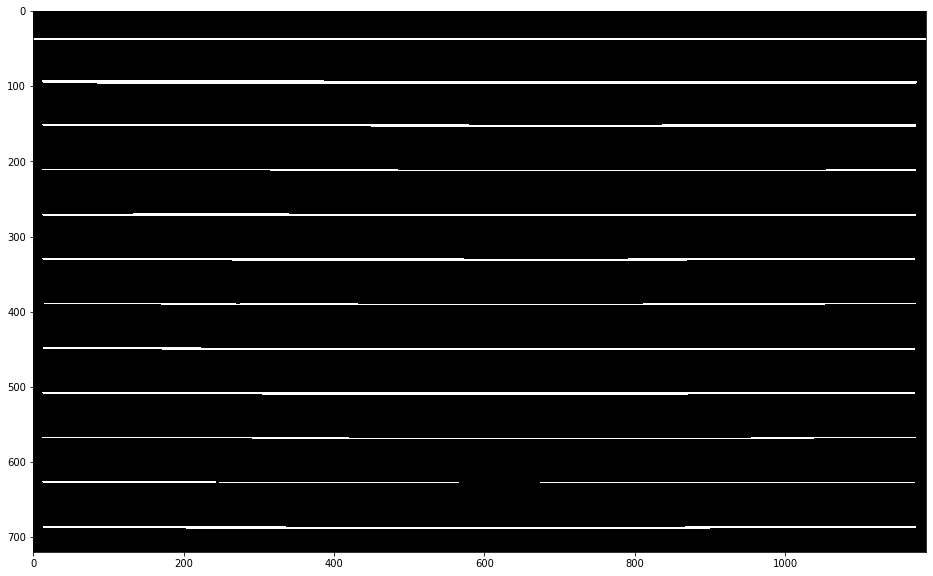

In [134]:
# find all lines:
binary = cv2.adaptiveThreshold(~ready_image, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -10)
rows, cols = binary.shape
scale = 20
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (cols // scale, 1))
eroded = cv2.erode(binary, kernel, iterations=2)
dilatedcol = cv2.dilate(eroded, kernel, iterations=2)
img_show(dilatedcol)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


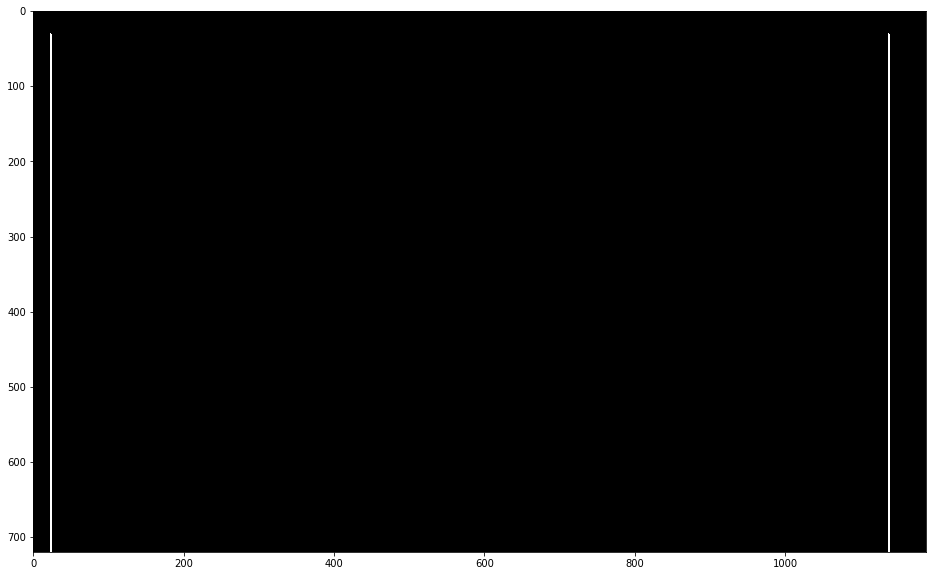

In [135]:
# find all vertical lines:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (1, rows // scale))
eroded = cv2.erode(binary, kernel, iterations=2)
dilatedrow = cv2.dilate(eroded, kernel, iterations=2)
img_show(dilatedrow)

In [136]:
# get vertex
vertex = cv2.bitwise_and(dilatedcol, dilatedrow)
print(np.where(vertex>0))

(array([ 37,  37,  37,  37,  37,  37,  38,  38,  38,  38,  38,  38,  39,
        39,  39,  39,  39,  39,  93,  93,  93,  94,  94,  94,  94,  94,
        94,  95,  95,  95,  95,  95,  95,  96,  96,  96,  96,  96,  96,
        97,  97,  97, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153,
       153, 153, 154, 154, 154, 211, 211, 211, 211, 211, 211, 212, 212,
       212, 212, 212, 212, 213, 213, 213, 271, 271, 271, 271, 271, 271,
       272, 272, 272, 272, 272, 272, 330, 330, 330, 330, 330, 330, 331,
       331, 331, 331, 331, 331, 389, 389, 389, 389, 389, 389, 390, 390,
       390, 390, 390, 390, 448, 448, 448, 449, 449, 449, 449, 449, 449,
       450, 450, 450, 507, 507, 507, 508, 508, 508, 508, 508, 508, 509,
       509, 509, 509, 509, 509, 567, 567, 567, 567, 567, 567, 568, 568,
       568, 568, 568, 568, 626, 626, 626, 627, 627, 627, 627, 627, 627,
       628, 628, 628, 685, 685, 685, 686, 686, 686, 686, 686, 686, 687,
       687, 687, 687, 687, 687]), array([  22,   23,   24, 1137

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


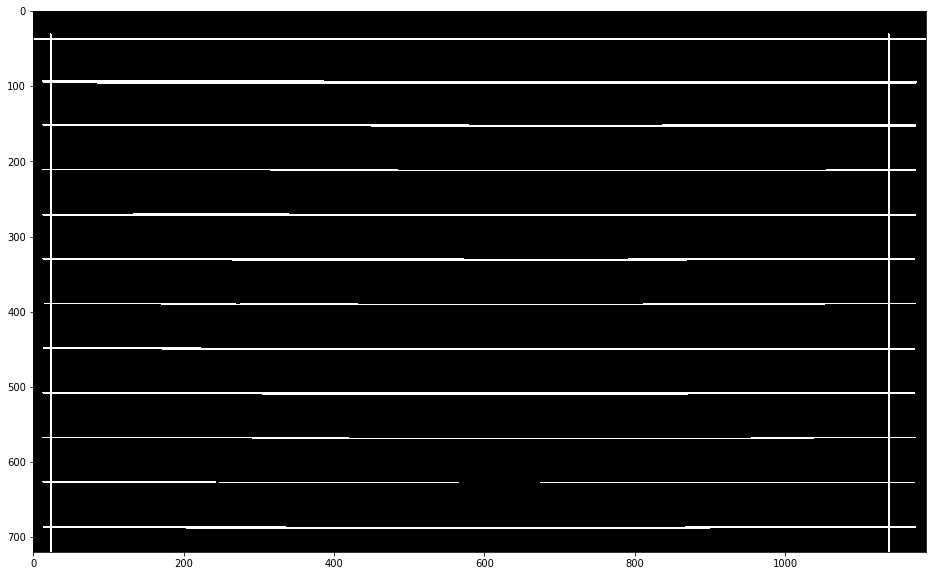

In [137]:
# plot cell
merge = cv2.add(dilatedcol, dilatedrow)
img_show(merge)

In [138]:
ys, xs = np.where(vertex > 0)
x_list, y_list = [], []

# sort list
xs, ys = np.sort(xs), np.sort(ys)
for i in range(len(xs) - 1):
    if xs[i+1] - xs[i] > 20:
        print(xs[i])

24


In [139]:
# get coordinate
ys, xs = np.where(vertex > 0)
x_list, y_list = [], []

# sort list
xs, ys = np.sort(xs), np.sort(ys)

for i in range(len(xs) - 1):
    if xs[i+1] - xs[i] > 20:
        x_list.append(xs[i])
x_list.append(xs[i])
if x_list[0] > 30:
    x_list.append(24)
x_list = sorted(x_list)

for i in range(len(ys) - 1):
    if ys[i+1] - ys[i] > 20:
        y_list.append(ys[i])
y_list.append(ys[i])

print(x_list)
print(y_list)

[24, 1139]
[39, 97, 154, 213, 272, 331, 390, 450, 509, 568, 628, 687]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


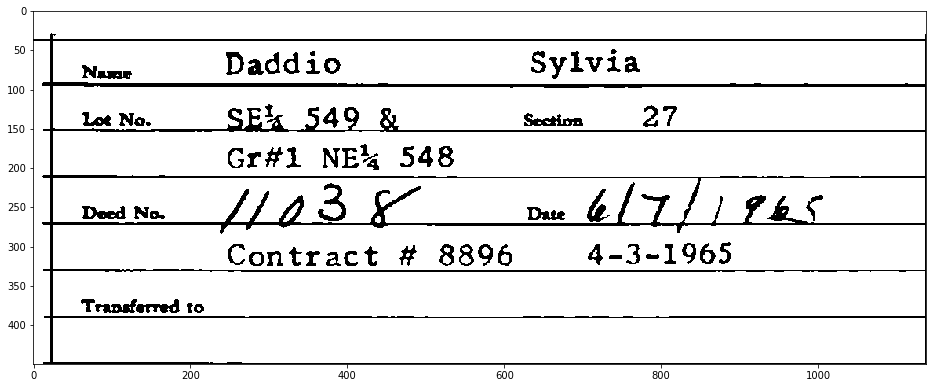

In [89]:
rec_image = ready_image[0:y_list[7], 0:w-50]
img_show(rec_image)

In [90]:
rects = []
for i in range(len(x_list) - 1):
    for j in range(len(y_list) - 1):
        rects.append(((x_list[i], y_list[j], x_list[i + 1], y_list[j + 1])))
print(rects)

[(24, 39, 1139, 97), (24, 97, 1139, 154), (24, 154, 1139, 213), (24, 213, 1139, 272), (24, 272, 1139, 331), (24, 331, 1139, 390), (24, 390, 1139, 450), (24, 450, 1139, 509), (24, 509, 1139, 568), (24, 568, 1139, 628), (24, 628, 1139, 687)]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


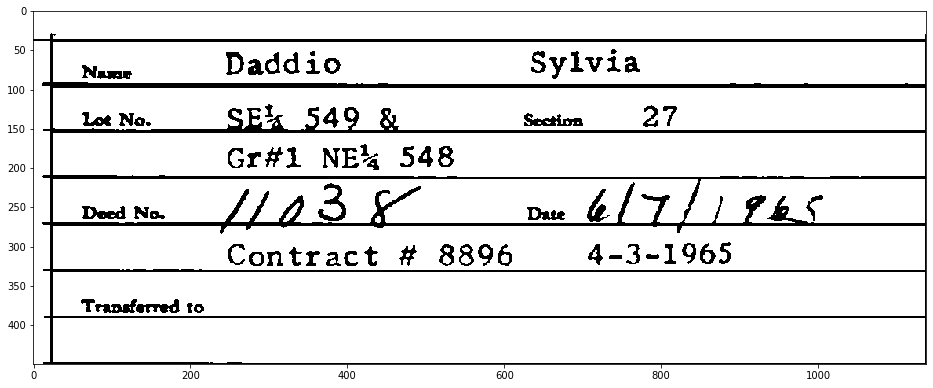

In [91]:
rect_ret = rects[:7]
for rect in rects:
    rec_image = cv2.rectangle(rec_image, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 0), 2)
img_show(rec_image)

In [99]:
file_name = ['Name', 'Lot-Sec-Gr', 'Deed No. & Date', 'Comments']
special_char = '‘’,|-_<"=;«“&—]uv'
result = {}
name = rects[0]
detect_img = rec_image[name[1]:name[3], name[0]:name[2]]
text = pytesseract.image_to_string(detect_img, config='-l eng --psm 10')
text = ''.join([char for char in text if char not in special_char])
ret = list(text.partition(' '))

print(ret[-1])

. Daddio   Sylia


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


 ene SEX 549  ss sets aT


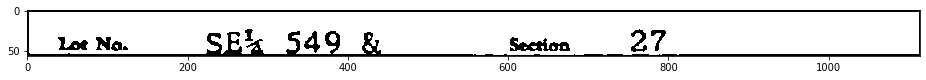

In [102]:
lot1 = rects[1]
detect_img = rec_image[lot1[1]:lot1[3], lot1[0]:lot1[2]]
text = pytesseract.image_to_string(detect_img, config='-l eng --psm 10')
text = ''.join([char for char in text if char not in special_char])
img_show(detect_img)
print(text)



In [112]:
def ocr_text(image, rect):
    file_name = ['Name', 'Lot-Sec-Gr', 'Deed No. & Date', 'Comments']
    special_char = '‘’,|-_<"=;«“&—]uv'
    result = {}
    temp = []
    for i in range(7):
        rect1 = rects[i]
        detect_img = image[rect1[1]:rect1[3], rect1[0]:rect1[2]]
        text = pytesseract.image_to_string(detect_img, config='-l eng --psm 10')
        text = ''.join([char for char in text if char not in special_char])
        ret = list(text.partition(' '))
        ret = ret[2:]
        temp.append(ret)
    
    result[file_name[0]] = temp[0]
    result[file_name[1]] = temp[1:3]
    result[file_name[2]] = temp[3:5]
    result[file_name[3]] = temp[5:]

        

    
    return result
        
        
    


In [113]:
ocr_text(rec_image, rect_ret)

{'Name': ['. Daddio   Sylia'],
 'Lot-Sec-Gr': [['ene SEX 549  ss sets aT'], ['NE 548']],
 'Deed No. & Date': [['pean. JSP AX we /7/) bE'], ['# 8896 431965']],
 'Comments': [['reamstered te'], ['']]}